# **Assignment \#4**: Machine Learning MC886/MO444
University of Campinas (UNICAMP), Institute of Computing (IC)

Prof. Sandra Avila, 2022s2

In [2]:
# TODO: RA & Name 
print('RA1: 231359' + ' Arthur Baia')
print('RA2: 200025' + ' Augusto Marcos')

RA1: 231359 Arthur Baia
RA2: 200025 Augusto Marcos


## Objective

Exploring **unsupervised learning techniques** by using dimensionality reduction techniques.

## Import Libraries

In [4]:
# Libraries are free to use! You can use Scikit-learn, Keras/TensorFlow, PyTorch, ... 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [5]:
#device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Dataset

Fashion-MNIST is a dataset of Zalando’s article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

Dataset Information:

- You should respect the following traininig/test split: 60,000 training examples, and 10,000 test examples. Avoid overfitting.

- The data is available at:
https://www.dropbox.com/s/qawunrav8ri0sp4/fashion-mnist-dataset.zip:
‘train’ folder (fashion-mnist train.csv.zip) + ‘test’ folder (fashion-mnist test.csv.zip).

  - You can also download the data by the framework you are using.

- Each training and test example is assigned to one of the following labels: 0 t-shirt/top, 1 trouser, 2 pullover, 3 dress, 4 coat, 5 sandal, 6 shirt, 7 sneaker, 8 bag, 9 ankle boot.
- Each row is a separate image. Column 1 is the class label. The remaining columns are pixel numbers (784 total). Each value is the darkness of the pixel (1 to 255). Dataset was converted to CSV with this script: https://pjreddie.com/projects/mnist-in-csv.

In [4]:
# Download Fashion-MNIST
#->
# get the files from a URL on dropbox
url = 'https://www.dropbox.com/s/qawunrav8ri0sp4/fashion-mnist-dataset.zip'
# download the file
!wget -O fashion-mnist-dataset.zip $url
# unzip the file
!unzip -q fashion-mnist-dataset.zip

# the dataset is now in the folder 'fashion-mnist-dataset' and the files are named fashion-mnist_train.csv.zip and fashion-mnist_test.csv.zip, unzip them
!unzip -q fashion-mnist-dataset/fashion-mnist_train.csv.zip -d fashion-mnist-dataset
!unzip -q fashion-mnist-dataset/fashion-mnist_test.csv.zip -d fashion-mnist-dataset


--2022-11-12 11:54:40--  https://www.dropbox.com/s/qawunrav8ri0sp4/fashion-mnist-dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/qawunrav8ri0sp4/fashion-mnist-dataset.zip [following]
--2022-11-12 11:54:41--  https://www.dropbox.com/s/raw/qawunrav8ri0sp4/fashion-mnist-dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc419e498644926e4d45733c8c8d.dl.dropboxusercontent.com/cd/0/inline/BwmAipa5R5WrGr_WvQKU_szalV34vJn6dHJ8liDBE2T8xlO3NKt4N-wmqe_Di0Xyb9kz4WthTRBKw7lulLk-Wx1XIKBds6HKim2MRhCBegRLyXsWRqjouWXBVWmSzLKgaUwWmxuU3L_4v0FRXSGepWA1eKnB5cnnEurB2dmi4n2jVw/file# [following]
--2022-11-12 11:54:43--  https://uc419e498644926e4d45733c8c8d.dl.dropboxusercontent.com/cd/0/inline/BwmAipa5R5WrGr_WvQKU_szalV34vJn6dHJ8liDBE

In [6]:
# Load the data
train = pd.read_csv('fashion-mnist-dataset/fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist-dataset/fashion-mnist_test.csv')

In [7]:
# split the train into train and validation

train, val = np.split(train, [int(.8*len(train))])

# convert the dataframes to numpy arrays

train = train.to_numpy()
val = val.to_numpy()
test = test.to_numpy()


x_train, y_train = train[:, 1:], train[:, 0]
x_val, y_val =  val[:, 1:], val[:, 0]

In [8]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((48000, 784), (48000,), (12000, 784), (12000,))

In [13]:
# reshape the data to 28x28 images
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
x_train.shape, x_val.shape

((48000, 28, 28, 1), (12000, 28, 28, 1))

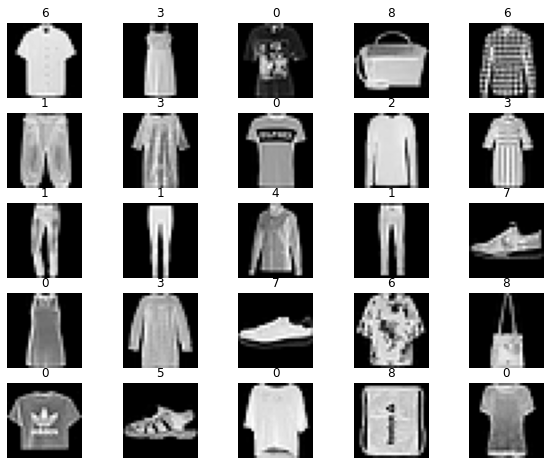

In [14]:
# Plot a data grid for general observation
#->
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(x_train), size=(1,)).item()
    img, label = x_train[sample_idx], y_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Activities

1. (2 points) Baseline: Explore Convolutional Neural Networks with Fashion-MNIST. What is the accuracy of your CNN model? (1.5 points) Describe your Convolutional Neural Network architecture. (0.5 points) What are your conclusions about the baseline?

In [26]:
# Create your convolutional neural network architecture to train fashion-MNIST
#->
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [32]:
def train(model, train_loader, loss_function, optimizer, epoch):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        # Forward pass
        outputs = model(train)
        loss = loss_function(outputs, labels)
        train_loss += loss.item()

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        # Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()

    return train_loss / len(train_loader.dataset)


In [33]:
def evalute(model, test_loader, loss_function):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(Variable(images.view(100, 1, 28, 28)))
            test_loss += loss_function(output, labels).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).sum()
    
    return test_loss/len(test_loader.dataset), 100.0 * correct / len(test_loader.dataset)



In [34]:
# Train loop

# ->
# Train loop
learning_rate = 0.001
model = FashionCNN()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 100
model = model.to(device)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.from_numpy(x_train).float(),
        torch.from_numpy(y_train).long(),
    ),
    batch_size=batch_size,
    shuffle=True,
)

val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.from_numpy(x_val).float(),
        torch.from_numpy(y_val).long(),
    ),
    batch_size=batch_size,
    shuffle=False,
)

num_epochs = 10




In [35]:
train_losses, val_losses, val_accs = [], [], []
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, loss_function, optimizer, epoch)
    train_losses.append(train_loss)
    val_loss, accuracy = evalute(model, val_loader, loss_function)
    val_losses.append(val_loss)
    val_accs.append(accuracy)

    print(
        "Epoch: {}, Train Loss: {:.4f}, Test Loss: {:.4f}, Accuracy: {:.2f}%".format(
            epoch, train_loss, val_loss, accuracy
        )
    )


/home/arthur/.local/lib/python3.8/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 0, Train Loss: 0.0047, Test Loss: 0.0038, Accuracy: 85.71%
Epoch: 1, Train Loss: 0.0031, Test Loss: 0.0033, Accuracy: 88.67%
Epoch: 2, Train Loss: 0.0027, Test Loss: 0.0028, Accuracy: 90.19%
Epoch: 3, Train Loss: 0.0024, Test Loss: 0.0027, Accuracy: 90.48%
Epoch: 4, Train Loss: 0.0022, Test Loss: 0.0030, Accuracy: 89.93%
Epoch: 5, Train Loss: 0.0021, Test Loss: 0.0027, Accuracy: 90.40%
Epoch: 6, Train Loss: 0.0019, Test Loss: 0.0026, Accuracy: 90.84%
Epoch: 7, Train Loss: 0.0018, Test Loss: 0.0030, Accuracy: 90.58%
Epoch: 8, Train Loss: 0.0017, Test Loss: 0.0028, Accuracy: 90.37%
Epoch: 9, Train Loss: 0.0016, Test Loss: 0.0030, Accuracy: 90.61%


In [37]:
# Report your accuracy using convolutional neural network
print(val_accs[-1].item())

90.60832977294922


In [ ]:
# What are your conclusions about the baseline? 

2. (2 points) Using PCA: Re-do the first experiment considering the PCA dimensionality reduction. (1.5 points) Consider two different energies (variance) for reducing the image dimensionality. (0.5 points) What are the conclusions when using PCA in this problem? Does the accuracy improve?

In [ ]:
# Run PCA methods

In [ ]:
# Re-do the first experiment considering the PCA dimensionality reduction

3. (0.5 point) What can we infer when analyzing the breakdown of data into components using a chart to plot the data in 2-dimensional space to view separation?

In [ ]:
# In order to see how the PCA components are separating out the digits, lets use the following method, plot_components, to plot the data in a 2 dimensional space to view separation.
# The input parameters are the PCA fit in X and the labels
def plot_components(X, y):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure(figsize=(10, 6))
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]), 
                 color=plt.cm.Set1(y[i]), 
                 fontdict={'size': 15})

    plt.xticks([]), plt.yticks([]), plt.ylim([-0.1,1.1]), plt.xlim([-0.1,1.1])

In [ ]:
# The input parameters are the PCA fit in X and the labels
plot_components(#?, #?)

4. (2 points) How many components are needed for a better evaluation of the model? Define the minimum and maximum components to be tested using the energies_number method. How can we evaluate this graph and the quantity that was defined as best for the problem?

In [ ]:
# Iteratively check how many principal components would be required in order to reach a reasonable accuracy with the same random neural network.

def energies_number(min, max, X):
    # Select a range of min and max number of dimensions, min/max.

    acc_list, pc_list = [], []
    for pc in range(min,max):
        pca = # Run the PCA algorithm for dimensionality reduction.
        acc = # Calculate the accuracy of the neural network using the reduced dimension by PCA
        acc_list.append(acc)
        pc_list.append(pc)
    return acc_list, pc_list

acc_list, pc_list = energies_number( #?, #? , #? )

In [ ]:
plt.figure(figsize=[12,9])
plt.scatter(pc_list, acc_list)
plt.title('Neural Network Plot Accuarcy as a Function of Number of Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Accuracy');

In [ ]:
print('The maximum accuracy attained is ',np.max(acc_list),'% with ',pc_list[np.where(acc_list == np.max(acc_list))[0][0]],' principal components. Beyond this peak, additional principal components appear to mostly contribute noise.')

5. (3.5 points) Using Autoencoders: Re-do the first experiment (question 2) considering Autoencoders for reducing the image dimensionality. (3 points) Consider two different latent vector sizes for reducing the image dimensionality. (0.5 points) What are the conclusions when using Autoencoders in this problem? Does accuracy improve? 

Autoencoders are a branch of neural networks which attempt to compress the information of the input variables into a reduced dimensional space and then recreate the input data set. Typically the autoencoder is trained over some iterations using gradient descent, minimizing the mean squared error.
The key component is the “bottleneck” hidden layer. This is where the information from the input has been compressed. By extracting this layer from the model, each node can be treated as a variable in the same way each chosen principal component is used in the following models.

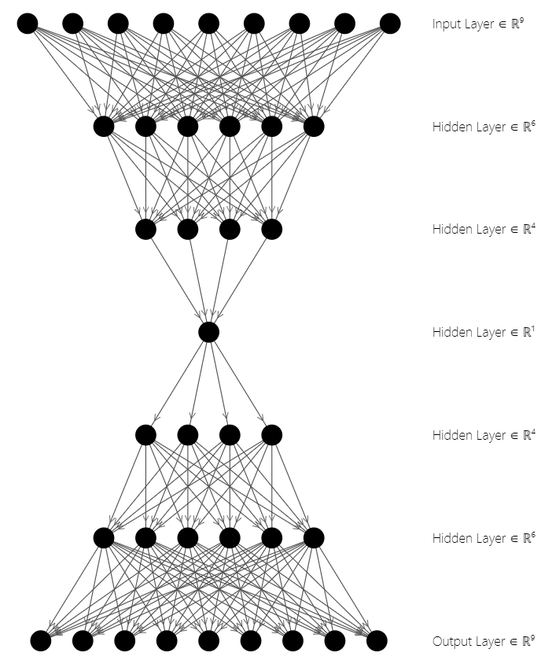

In [ ]:
# Create your AutoEncoder network architecture:

In [ ]:
# Re-do the first experiment (question 2) considering the autoencoder dimensionality reduction

In [ ]:
# What are the conclusions when using Autoencoders in this problem? Does accuracy improve?

## Deadline

Monday, November 18, 11:59 pm. 

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you do, your grade will be penalized as follows:
- November 19, 11:59 pm : grade * 0.75
- November 20, 11:59 pm : grade * 0.5
- November 21, 11:59 pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English).

**This activity is NOT individual, it must be done in pairs (two-person group).**